# NLP and Sentiment Analysis based Trading Strategy

In this case study we use NLP to build a trading strategy combining some of the concepts that we went through in some of the previous chapters.



Data used for this project will be from three sources 

* **News headlines data compiled from RSS feeds of several news websites**:
    This news headlines data is complied by different news website and contains the most financially relevant news filtered by human editors. For the purpose of this study, we will only look at the headline, not the details in the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from to 2011-05-02 to 2018-12-28
* **Yahoo finance website for the stock return**
* **Kaggle**: Labelled data of news sentiments used for classification on sentiment analysis
    - The data from the kaggle website is a stock market lexicon based on stock market conversations mainly from microblogging services: _Oliveira, Nuno, Paulo Cortez, and Nelson Areal. "Stock market sentiment lexicon acquisition using microblogging data and statistical measures." Decision Support Systems 85 (2016): 62-73._
    

In [4]:
%matplotlib inline

In [5]:
import pkg_resources
import pip

installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {
    'nltk', 'spacy', 'textblob', 'backtrader', 'pandas', 'matplotlib', 'yfinance',
    'scikit-learn', 'tensorflow', 'scikeras', 'statsmodels', 'seaborn', 'lxml', 'numpy',
    'scipy', 'copy', 'datetime'
}
missing = required - installedPackages

if missing:
    if 'nltk' in missing:
        !pip install nltk==3.4
    if 'spacy' in missing:
        !pip install -U spacy==2.2.0
        !python -m spacy download en_core_web_lg  # Or en_core_web_sm depending on the size of the model
    if 'textblob' in missing:
        !pip install textblob==0.15.3
    if 'backtrader' in missing:
        !pip install backtrader==1.9.74.123
    if 'pandas' in missing:
        !pip install pandas
    if 'matplotlib' in missing:
        !pip install matplotlib
    if 'yfinance' in missing:
        !pip install yfinance
    if 'scikit-learn' in missing:
        !pip install scikit-learn
    if 'tensorflow' in missing:
        !pip install tensorflow
    if 'scikeras' in missing:
        !pip install scikeras
    if 'statsmodels' in missing:
        !pip install statsmodels
    if 'seaborn' in missing:
        !pip install seaborn
    if 'lxml' in missing:
        !pip install lxml
    if 'numpy' in missing:
        !pip install numpy
    if 'scipy' in missing:
        !pip install scipy
    if 'copy' in missing:
        !pip install copy
    if 'datetime' in missing:
        !pip install datetime


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ERROR: Could not find a version that satisfies the requirement copy (from versions: none)
ERROR: No matching distribution found for copy


Loading the libraries

In [6]:
!python3 -m pip install textblob

In [7]:
#NLP libraries
from textblob import TextBlob
import subprocess
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd
import numpy as np 

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding
from tensorflow.keras.layers import Embedding
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential



# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import json  
import zipfile
import os.path
import sys
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hrishimehta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_lg' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [8]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
start = '2010-01-01'
end = '2018-12-31'

# Initialize an empty DataFrame to store all ticker data
df_ticker_return = pd.DataFrame()

# Loop over each ticker and fetch the data
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    data_temp = ticker_yf.history(start=start, end=end)
    data_temp['ticker'] = ticker  
    df_ticker_return = pd.concat([df_ticker_return, data_temp], ignore_index=False)

# Save the combined DataFrame to a CSV file
df_ticker_return.to_csv('Data/ReturnData.csv')

# Display the first few rows to confirm structure
print(df_ticker_return.head(2))

                               Open      High       Low     Close     Volume  \
Date                                                                           
2010-01-04 00:00:00-05:00  6.429937  6.462173  6.398304  6.447411  493729600   
2010-01-05 00:00:00-05:00  6.465187  6.495012  6.424516  6.458559  601904800   

                           Dividends  Stock Splits ticker  
Date                                                       
2010-01-04 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-05 00:00:00-05:00        0.0           0.0   AAPL  


Let us see the content of the json file

In [10]:
file = zipfile.ZipFile("Data/Raw_Headline_Data.zip", "r")
testFile=file.namelist()[10]
fileData= file.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  
fileDataSample

'li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr'

Need to change the json format, not correct for the algorithm we are building. 
We need to extract the news from the jsons
Utilizng regex to find the patterns in raw text

In [11]:
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return tickers, final_headlines

In [12]:
jsonParser(json.loads(fileData))[1][3]

'Shares of Globecomm Systems (GCOM +10.3%) surge after news that the satellite-based communications company has hired JPMorgan as a financial advisor, a move that could lead to a sale of the company. A potential deal could value the company at $22/share, according to Deal Reporter.'

The News Headlines are now extracted from the JSON's  
                                                                                Now we extract the tickers and headlines from each JSON file, and input it into a dataframe

In [13]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Data/Raw_Headline_Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               

            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Parse the  Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass  

In [14]:
data_df_news=pd.concat(data_df_news)
data_df_news.head()

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02


As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return.

In [15]:
df_ticker_return

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-01-04 00:00:00-05:00,6.429937,6.462173,6.398304,6.447411,493729600,0.0,0.0,AAPL
2010-01-05 00:00:00-05:00,6.465187,6.495012,6.424516,6.458559,601904800,0.0,0.0,AAPL
2010-01-06 00:00:00-05:00,6.458559,6.484167,6.349199,6.355827,552160000,0.0,0.0,AAPL
2010-01-07 00:00:00-05:00,6.379326,6.386858,6.297984,6.344078,477131200,0.0,0.0,AAPL
2010-01-08 00:00:00-05:00,6.335642,6.386857,6.298285,6.386254,447610800,0.0,0.0,AAPL
...,...,...,...,...,...,...,...,...
2018-12-21 00:00:00-05:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE
2018-12-24 00:00:00-05:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE
2018-12-26 00:00:00-05:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE


## Prepare the Combines Data 

We will now extract the event return, the return for each event. We need to capture a wide window of the event, as sometimes the news event can occur after market close or the news may be reported late.  

Equation for Event Return: $R_{t-1} + R_{t} + R_{t+1}$  
In this equation $R_{t-1}$ and $R_{t+1}$ are both the returns before and after the news event, while $R_t$ is the return on the day of the news

In [16]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()

#Computing the event return
df_ticker_return['eventReturn'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

Now we will create the dataframe with the news headlines mapped to the dates, stock tickers and event returns. 

In [17]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventReturn','Close']]
data_df = data_df.dropna()

In [18]:
data_df.head(2)

,ticker,headline,date,eventReturn,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285


In [19]:
data_df.dropna().to_csv(r'Data/NewsAndReturnData.csv', sep='|', index=False)

In [20]:
data_df = pd.read_csv(r'Data/NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()
data_df

,ticker,headline,date,eventReturn,Close
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,19.844744
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,19.844744
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500
...,...,...,...,...,...
2458,TSLA,Morgan Stanley sees the rally in Tesla (NASDAQ...,2018-12-18,-0.092015,22.468666
2459,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,19.692667
2460,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,67.197998
2461,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005652,35.060493


## Sentiment Analysis

In this part, we will be using three different approaches of getting senitments for thw news strategies, in which we will use for the trading strategy. 


### 1) Textblob Sentiment Function

This function uses a pretrained model based on a Naïve Bayes classification algorithm to assign a sentiment score to sentences, ranging from -1 to +1. It evaluates adjectives commonly found in movie reviews (source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html ), producing sentiment polarity scores from -1 (negative) to +1 (positive), along with a subjectivity score from 0 (objective) to 1 (subjective). We apply this model to analyze sentiment across all article headlines in our dataset.

In [21]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 
data_df

,ticker,headline,date,eventReturn,Close,sentiment_textblob
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.262500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,-0.043750
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,19.844744,0.166667
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,19.844744,-0.030556
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,0.000000
...,...,...,...,...,...,...
2458,TSLA,Morgan Stanley sees the rally in Tesla (NASDAQ...,2018-12-18,-0.092015,22.468666,0.000000
2459,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,19.692667,-0.156250
2460,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,67.197998,0.200000
2461,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005652,35.060493,-0.012500


Scatterplot between sentiment and Event Return 

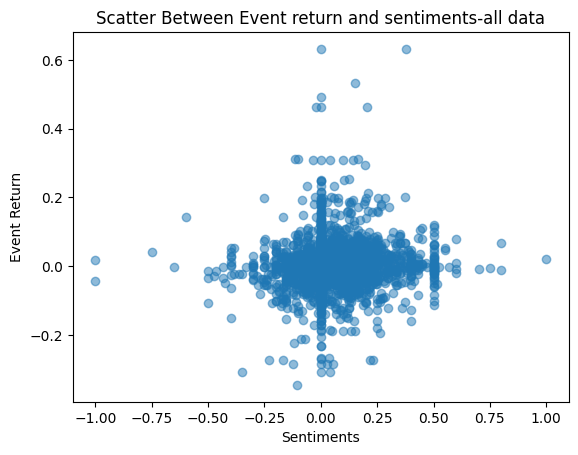

In [22]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventReturn'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

The plot above agrees with natural intuition, it shows a positive correlation between event returns and sentiments. 

In [23]:
corrlation = data_df['eventReturn'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.06646046372141523


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

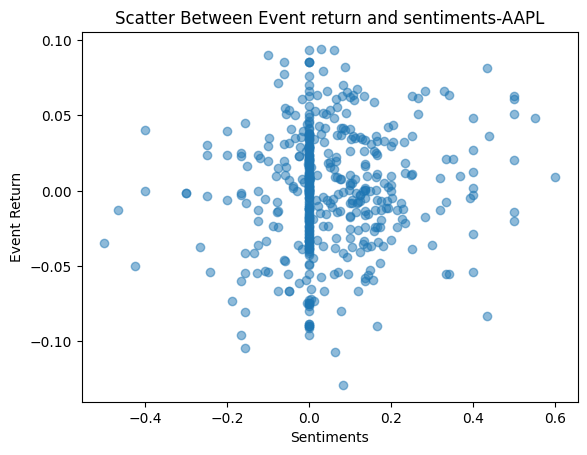

In [24]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventReturn'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments for AAPL. Also, there are a lot of sentiments centred around 0. 

In [25]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. 

## Classification Algorithms and LSTM (Supervised Learning)

The data used for this model is obtainred from the kaggle website. 

In [26]:
sentiments_data = pd.read_csv(r'Data/LabelledNewsData.csv',encoding = "ISO-8859-1")

In [27]:
sentiments_data.head(10)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0
5,1/6/2020 15:54,$MMM - 3M: The Fallen Dividend King Will Be Ba...,MMM,1
6,1/2/2020 14:35,$MMMcelebrates New Year with 7 month high clos...,MMM,1
7,1/2/2020 10:13,$MMM above 180 baby is going higher,MMM,1
8,12/28/2019 15:04,"$MMMhasn't really done much this year, but it ...",MMM,1
9,12/27/2019 0:28,3M $MMM Rating Increased to Neutral at JPMorga...,MMM,1


As you can see above, the data is headlines for news across many different stocks, there is 9470 rows and 30 columns(tickers).  
  
  
In order to run a supervised learning model, we need to convert the news headlines into feature representations.

In [28]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


In [29]:
#word-embedding
all_vectors = np.array([np.array([token.vector for token in nlp(s) ]).mean(axis=0)*np.ones((300)) \
                           for s in sentiments_data['headline']])

Now that we have the independent variable, we train the classification model.  
First we divide the data into training and test set

In [30]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors


validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

In [31]:

results = []
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)  # Set shuffle=True
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))



LR: 0.873133 (0.006894) 0.893951 0.870468
[[1035  169]
 [ 199 1438]]
KNN: 0.759392 (0.013987) 0.848243 0.763816
[[ 842  279]
 [ 392 1328]]
CART: 0.695883 (0.016902) 0.999698 0.684266
[[ 753  416]
 [ 481 1191]]
SVM: 0.831200 (0.015621) 0.862875 0.833861
[[ 955  193]
 [ 279 1414]]
NN: 0.896968 (0.009932) 0.997737 0.906723
[[1080  111]
 [ 154 1496]]
RF: 0.790166 (0.011511) 0.999698 0.787399
[[ 829  199]
 [ 405 1408]]


In [32]:
print(classification_report(res.predict(X_test), Y_test))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      1028
           1       0.88      0.78      0.82      1813

    accuracy                           0.79      2841
   macro avg       0.77      0.79      0.78      2841
weighted avg       0.80      0.79      0.79      2841



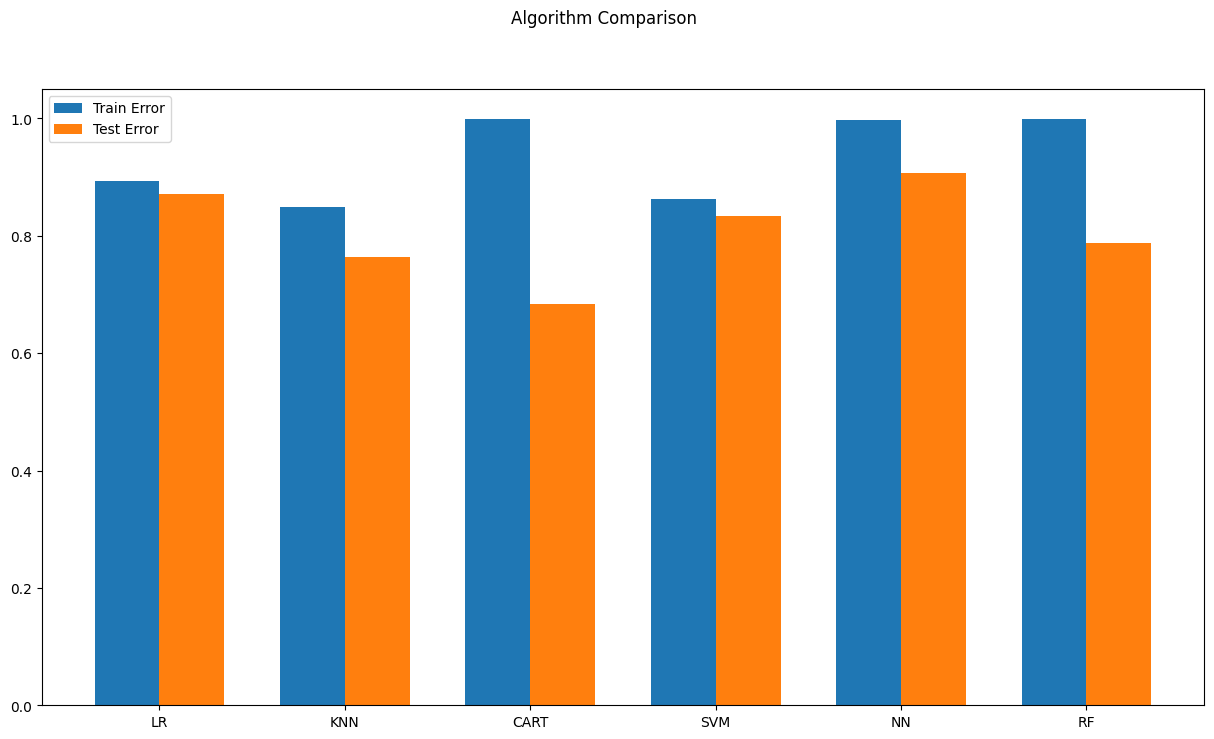

In [33]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As we can see the Neural Network Model is the best performing model with a training accuracy of 99%, and a test accuracy of 93%. The SVM, Logistic Regression, and Random Forest performed good as well, while the CART and KNN dont perform as good as the others. The CART model struggles with overfitting as well. 

## LSTM Model 

For NLP based models, RNN architecture is preferred over other machine learning models as the RNN will store the information of the current feature as well as the neighboring features for prediction

In [34]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

Dividing the data into the training and test set. 

In [35]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In the following code snippet, we used Keras library to build a neural network classifier.

In [36]:
print("X_train_LSTM shape:", X_train_LSTM.shape)
print("Y_train_LSTM shape:", Y_train_LSTM.shape)


X_train_LSTM shape: (6629, 50)
Y_train_LSTM shape: (6629,)


In [37]:
all_texts = np.concatenate((X_train_LSTM, X_test_LSTM), axis=0)
print(all_texts.shape)  # Should be (6629 + 2841, 50)

(9470, 50)


In [38]:
from keras import backend as K
K.clear_session()


In [39]:
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(input_dim=20000, output_dim=300, input_shape=(input_length,)))  # Use input_shape
    model.add(LSTM(100, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    

# Check X_train_LSTM shape, and reshape if necessary
X_train_LSTM = np.array(X_train_LSTM)
Y_train_LSTM = np.array(Y_train_LSTM)

print("X_train_LSTM shape:", X_train_LSTM.shape)  # Should be (num_samples, input_length)

# Initialize the KerasClassifier without validation_split for troubleshooting
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1)

# Fit the model
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)


X_train_LSTM shape: (6629, 50)
Epoch 1/3
208/208 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7798 - loss: 0.4260
Epoch 2/3
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9916 - loss: 0.0341
Epoch 3/3
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9960 - loss: 0.0116


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x30e1dc430>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=3
	class_weight=None
)

In [40]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)
test_result_LSTM

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


0.9743048222456882

Computing the accuracy and confusion metrics. 

In [41]:
print(train_result_LSTM,test_result_LSTM)

0.9989440337909187 0.9743048222456882


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion Matrix:
 [[1213   21]
 [  52 1555]]


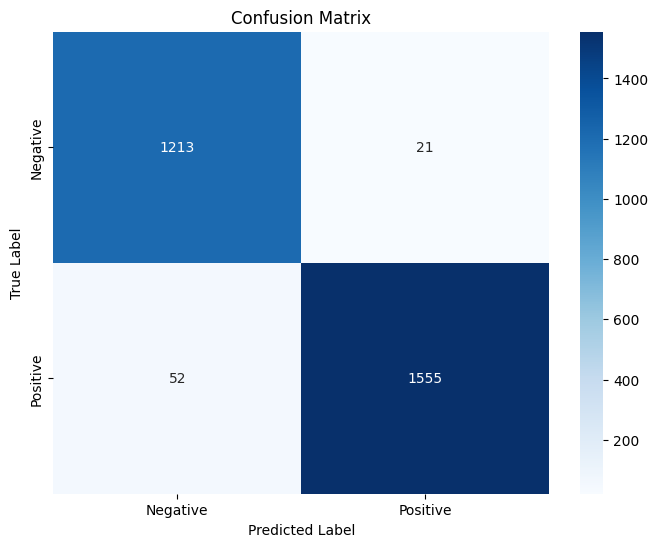

In [42]:
from sklearn.metrics import confusion_matrix
# Generate predictions from the model
predictions = model_LSTM.predict(X_test_LSTM)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(Y_test_LSTM, predicted_labels)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [43]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)

In [44]:
names.append("LSTM")

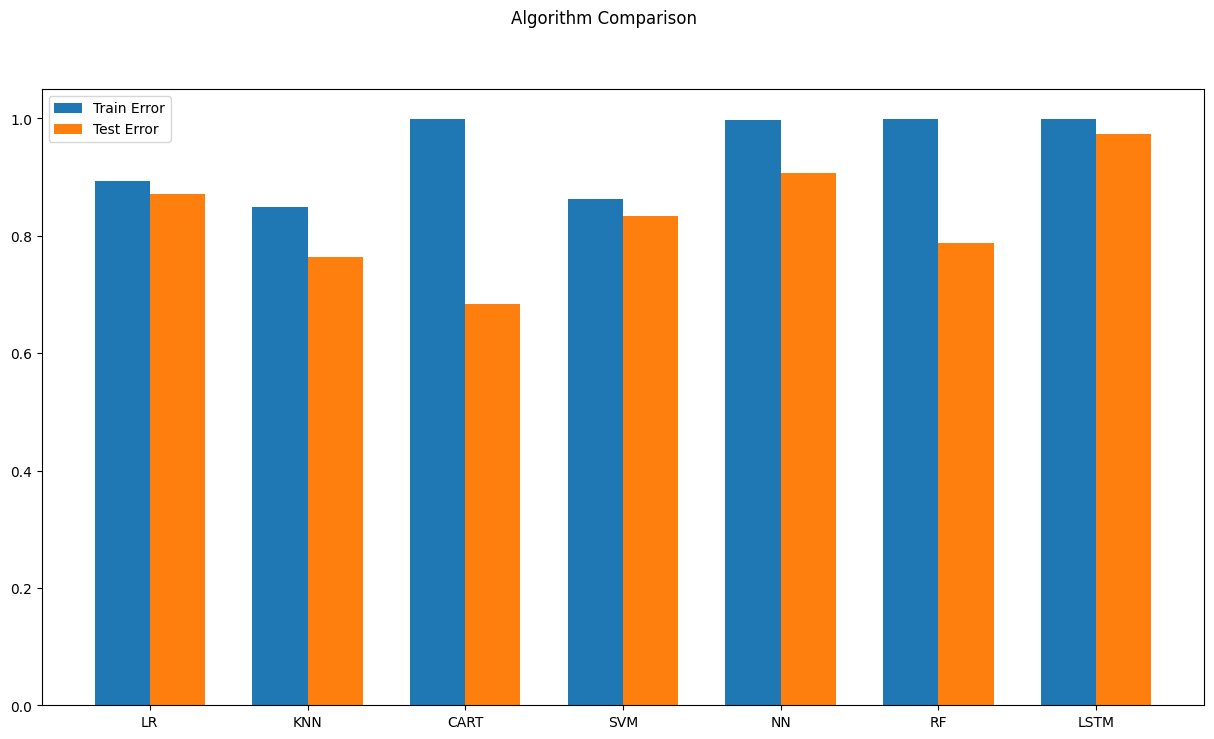

In [45]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

As we had expected, the LSTM model has the best performance in the test set in comparance to other models we had tested before.  
  
  The LSTM will now be used for the computation of sentiments in data

In [46]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [47]:
Y_LSTM = model_LSTM.predict(X_LSTM)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [48]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [49]:
corrlation = data_df['eventReturn'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.1064268619325875


In [50]:
data_df.head(1)

,ticker,headline,date,eventReturn,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,10.0595,0.2625,0


## Model on Financial Lexicon (Unsupervised)
  
Lexicons - Special Dictionaries/Vocabularies that are created for analyzing sentiments  
VADER ( Valence Aware Dictionary for Entiment Reasoning) : pre built sentiment analysis model included in the NLTK package 

In [51]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('Data/LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex


Example of extracting sentiment score for a sentence:

In [52]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [53]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [54]:
vader_sentiments = np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2454,)

In [55]:
data_df['sentiment_lex'] = vader_sentiments

In [56]:
corrlation = data_df['eventReturn'].corr(data_df['sentiment_lex'])
print(corrlation)

0.16746447084724594


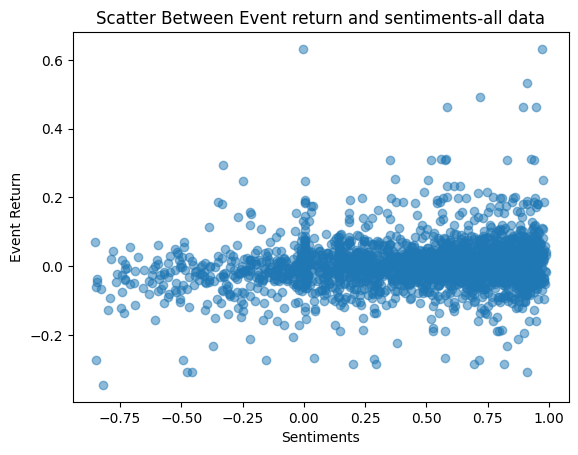

In [57]:
plt.scatter(data_df['sentiment_lex'],data_df['eventReturn'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

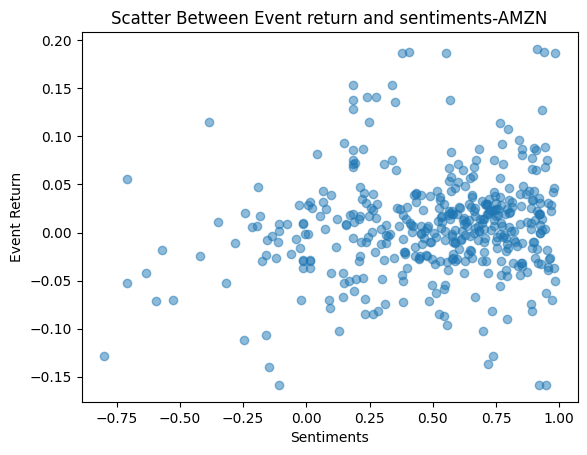

In [58]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventReturn'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [59]:
data_df.to_csv(r'Data/DataWithSentimentsResults.csv', sep='|', index=False)

### Exploratory Data Analysis

In [60]:
data_df = pd.read_csv(r'Data/DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

In [61]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,1,0.8575


Looking at this headline above we can see that the sentiment is positive

<Axes: title={'center': 'Correlation Matrix'}>

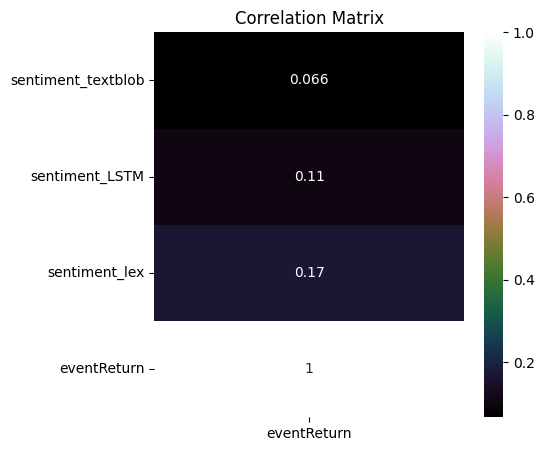

In [62]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventReturn']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventReturn']], vmax=1, annot=True,cmap='cubehelix')

All the sentiments have positive relationship with the return which is intuitive and expected. 

In [63]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventReturn'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventReturn'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventReturn'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [64]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.019830,0.187939,0.138296
NFLX,0.092592,0.047633,0.218749
MSFT,-0.025433,0.207211,0.034609
GOOG,0.044247,0.228027,0.196270
JPM,-0.160508,0.098457,0.025228
TSLA,0.118400,0.094680,0.213664
AAPL,0.108411,0.147001,0.217611
WMT,0.186673,0.129466,0.102348
ADBE,0.033785,0.274500,0.130326


The correlation from the lexicon methodology is the highest among all the stock tickers

In [97]:
data_df

,ticker,headline,date,eventReturn,Close,sentiment_textblob,sentiment_LSTM,sentiment_lex
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.262500,0,0.2115
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,-0.043750,1,0.8575
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019817,19.844744,0.166667,1,0.6971
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019817,19.844744,-0.030556,1,0.7751
4,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,0.000000,1,-0.0413
...,...,...,...,...,...,...,...,...
2449,TSLA,Morgan Stanley sees the rally in Tesla (NASDAQ...,2018-12-18,-0.092015,22.468666,0.000000,0,0.3717
2450,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,19.692667,-0.156250,0,0.6713
2451,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,67.197998,0.200000,1,0.6419
2452,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005652,35.060493,-0.012500,1,-0.5961


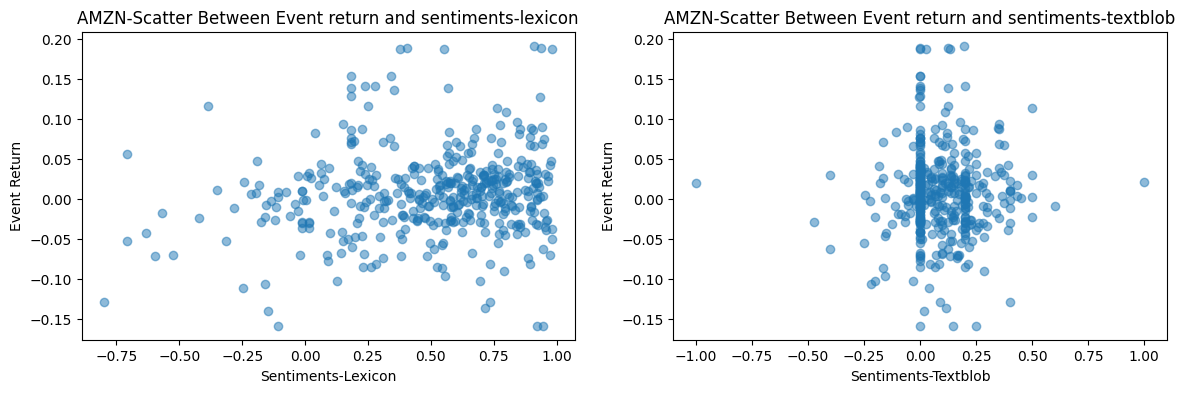

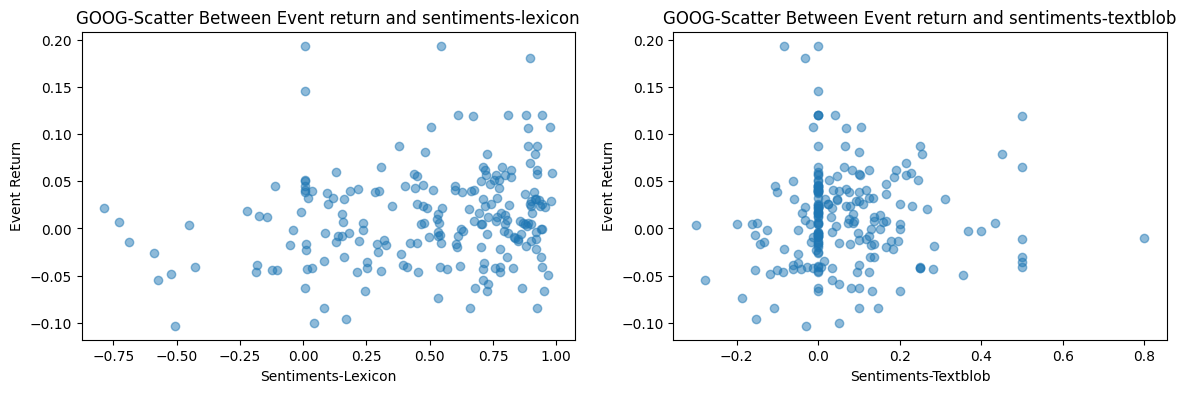

In [99]:
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventReturn'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventReturn'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()

The lexicon based sentiments on the left show a positive relationship between sentiments and return.  
  
  We will use the lexicons for the trading strategy

## Model Evaluation - Trading Strategy

The sentiment data can be leveraged in various ways within a trading strategy. Sentiment scores can act as a directional indicator, helping to form a long-short portfolio by purchasing stocks with positive sentiment scores and shorting those with negative sentiment scores. Sentiments can also serve as additional features in a supervised learning model, alongside other factors like correlated stocks or technical indicators, to predict stock prices or develop a trading strategy.

In the trading strategy outlined in this case study, we make buy and sell decisions based on the current sentiment of the stock:

A stock is bought when the change in sentiment score (current sentiment score minus previous sentiment score) exceeds 0.5.
A stock is sold when the sentiment change falls below -0.5.
Additionally, we incorporate a 15-day moving average as part of the decision-making process for buying and selling, and trades are executed in units of 100 shares.

Of course, there are numerous ways to adapt this sentiment-based trading strategy, such as adjusting the threshold or varying the number of units depending on the available initial capital.

For this strategy, we use lexicon-based sentiment analysis.

#### Setting up the strategy 

Here we use backtrader which is a Python based API for writing and backtesting trading strategy. . Backtrader allows you to focus on writing reusable trading strategies, indicators and analyzers instead of having to spend time building infrastructure. we have a convenient framework to backtest and write our trading strategy. We used the Quickstart code in the docs (i.e. Refer to https://www.backtrader.com/docu/quickstart/quickstart/) as a base and modified it to include the sentiment scores.

We imlement a simple strategy to buy if the previous day’s sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5.  
  
    
    The following strategy is created in backtester_strategy.py

### Results for Inidividual Stocks

Backtesting on Google

In [65]:
ticker = 'GOOG'
date_sentiment = data_df[data_df['ticker'].isin([ticker])]
date_sentiment = date_sentiment[['date', 'sentiment_lex']]
date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

# Save the DataFrame to CSV
date_sentiment.to_csv('date_sentiment_google.csv')

# Convert to dictionary if needed for other purposes
date_sentiment_google = date_sentiment.to_dict()


In [66]:
ticker = 'GOOG'
start_date = '2012-01-01'
end_date = '2018-12-12'
sentiment_csv_file = 'Data/date_sentiment_google.csv'  # Ensure this file exists

# Run the backtest strategy script
subprocess.run(['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_csv_file])


Running strategy for GOOG


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.17
2012-04-13, BUY EXECUTED, Price: 16.09, Cost: 1608.88, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.27
2012-10-19, SELL EXECUTED, Price: 17.53, Cost: 1608.88, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.18, NET 144.18
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.42
2013-01-11, BUY EXECUTED, Price: 18.44, Cost: 1843.55, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.54
2014-07-18, SELL EXECUTED, Price: 29.50, Cost: 1843.55, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 1106.09, NET 1106.09
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 29.60
2014-07-21, BUY EXECUTED, Price: 29.43, Cost: 2943.42, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 28.63
2014-09-15, SELL EXECUTED, Price: 28.50, Cost: 2943.42, Comm 0.00
2014-09-1

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


CompletedProcess(args=['python3', 'backtest_strategy.py', 'GOOG', '2012-01-01', '2018-12-12', 'Data/date_sentiment_google.csv'], returncode=0)

Looking on one of the days a buy wa striggered, and we look at the news on that day and the precvious day

In [67]:
GOOG_ticker= data_df[data_df['ticker'].isin([ticker])]
New= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-17']['headline'])
Old= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-16']['headline'])
print("Current News:",New,"\n\n","Previous News:", Old)

Current News: ["Axiom Securities has upgraded Google (GOOG +13.4%, GOOGL +14.8%) to Buy following the company's Q2 beat and investor-pleasing comments about spending discipline, potential capital returns, and YouTube/mobile growth. MKM has launched coverage at Buy, and plenty of other firms have hiked their targets. Google's market cap is now above $450B."] 

 Previous News: ["While Google's (GOOG, GOOGL) Q2 revenue slightly missed estimates when factoring traffic acquisitions costs (TAC), its ex-TAC revenue of $14.35B was slightly above a $14.3B consensus. The reason: TAC fell to 21% of ad revenue from Q1's 22% and Q2 2014's 23%. That also, of course, helped EPS beat estimates.", 'Google (NASDAQ:GOOG): Q2 EPS of $6.99 beats by $0.28.']


Clearly the News on the current day has positive sentiment as compared to the news at the previous day causing the buy to be triggered. 

Backtesting on MSFT

In [68]:
ticker = 'MSFT'
date_sentiment = data_df[data_df['ticker'].isin([ticker])]
date_sentiment = date_sentiment[['date', 'sentiment_lex']]
date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

# Save the DataFrame to CSV
date_sentiment.to_csv('Data/date_sentiment_msft.csv')

# Convert to dictionary if needed for other purposes
date_sentiment_msft = date_sentiment.to_dict()

In [69]:
ticker = 'MSFT'
start_date = '2012-01-01'
end_date = '2018-12-12'
sentiment_csv_file = 'Data/date_sentiment_msft.csv'  # Ensure this file exists

# Run the backtest strategy script
subprocess.run(['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_csv_file])


Running strategy for MSFT


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-03-08, Previous Sentiment -0.50, New Sentiment 0.92 BUY CREATE, 25.42
2012-03-09, BUY EXECUTED, Price: 25.49, Cost: 2549.19, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 24.79
2012-04-05, SELL EXECUTED, Price: 24.74, Cost: 2549.19, Comm 0.00
2012-04-05, OPERATION PROFIT, GROSS -75.44, NET -75.44
2012-06-19, Previous Sentiment 0.15, New Sentiment 0.88 BUY CREATE, 24.54
2012-06-20, BUY EXECUTED, Price: 24.72, Cost: 2472.39, Comm 0.00
2012-07-12, Previous Sentiment 0.68, New Sentiment -0.65 SELL CREATE, 22.89
2012-07-13, SELL EXECUTED, Price: 22.99, Cost: 2472.39, Comm 0.00
2012-07-13, OPERATION PROFIT, GROSS -173.46, NET -173.46
2012-11-01, Previous Sentiment -0.69, New Sentiment 0.59 BUY CREATE, 23.75
2012-11-02, BUY EXECUTED, Price: 23.81, Cost: 2380.95, Comm 0.00
2012-11-13, Previous Sentiment 0.96, New Sentiment 0.13 SELL CREATE, 21.98
2012-11-14, SELL EXECUTED, Price: 22.10, Cost: 2380.95, Comm 0.00
2012-11-

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


CompletedProcess(args=['python3', 'backtest_strategy.py', 'MSFT', '2012-01-01', '2018-12-12', 'Data/date_sentiment_msft.csv'], returncode=0)

### Backtesting on All Stock Tickers

In [70]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker and run the backtest strategy
# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    date_sentiment.to_csv(sentiment_file)

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2012-01-01'
    end_date = '2018-12-12'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    subprocess.run(['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file])

    print(f"Backtest complete for {ticker}. Sentiment data saved in {sentiment_file}")

Running strategy for AAPL


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.27
2013-12-16, BUY EXECUTED, Price: 17.29, Cost: 1729.32, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.70
2014-09-26, SELL EXECUTED, Price: 21.85, Cost: 1729.32, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 455.42, NET 455.42
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.72
2014-10-22, BUY EXECUTED, Price: 22.80, Cost: 2280.30, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 28.87
2015-06-12, SELL EXECUTED, Price: 28.78, Cost: 2280.30, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 597.66, NET 597.66
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 26.01
2015-09-15, BUY EXECUTED, Price: 26.14, Cost: 2614.49, Comm 0.00
2015-12-14, Previous Sentiment 0.24, New Sentiment -0.62 SELL CREATE, 25.48
2015-12-15, SELL EXECUTED, Price: 25.35, Cost: 2614.49, Comm 0.00
2015-12-15,

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Backtest complete for AAPL. Sentiment data saved in Data/date_sentiment_aapl.csv
Running strategy for MSFT


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-03-08, Previous Sentiment -0.50, New Sentiment 0.92 BUY CREATE, 25.42
2012-03-09, BUY EXECUTED, Price: 25.49, Cost: 2549.19, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 24.79
2012-04-05, SELL EXECUTED, Price: 24.74, Cost: 2549.19, Comm 0.00
2012-04-05, OPERATION PROFIT, GROSS -75.44, NET -75.44
2012-06-19, Previous Sentiment 0.15, New Sentiment 0.88 BUY CREATE, 24.54
2012-06-20, BUY EXECUTED, Price: 24.72, Cost: 2472.39, Comm 0.00
2012-07-12, Previous Sentiment 0.68, New Sentiment -0.65 SELL CREATE, 22.89
2012-07-13, SELL EXECUTED, Price: 22.99, Cost: 2472.39, Comm 0.00
2012-07-13, OPERATION PROFIT, GROSS -173.46, NET -173.46
2012-11-01, Previous Sentiment -0.69, New Sentiment 0.59 BUY CREATE, 23.75
2012-11-02, BUY EXECUTED, Price: 23.81, Cost: 2380.95, Comm 0.00
2012-11-13, Previous Sentiment 0.96, New Sentiment 0.13 SELL CREATE, 21.98
2012-11-14, SELL EXECUTED, Price: 22.10, Cost: 2380.95, Comm 0.00
2012-11-

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Backtest complete for MSFT. Sentiment data saved in Data/date_sentiment_msft.csv
Running strategy for AMZN
Starting Portfolio Value: 100000.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


2013-01-30, Previous Sentiment 0.40, New Sentiment 0.95 BUY CREATE, 13.64
2013-01-31, BUY EXECUTED, Price: 13.55, Cost: 1355.20, Comm 0.00
2013-04-18, Previous Sentiment 0.89, New Sentiment 0.38 SELL CREATE, 12.97
2013-04-19, SELL EXECUTED, Price: 12.91, Cost: 1355.20, Comm 0.00
2013-04-19, OPERATION PROFIT, GROSS -64.40, NET -64.40
2013-10-25, Previous Sentiment 0.15, New Sentiment 0.84 BUY CREATE, 18.17
2013-10-28, BUY EXECUTED, Price: 18.00, Cost: 1799.60, Comm 0.00
2014-02-03, Previous Sentiment 0.56, New Sentiment -0.15 SELL CREATE, 17.31
2014-02-04, SELL EXECUTED, Price: 17.48, Cost: 1799.60, Comm 0.00
2014-02-04, OPERATION PROFIT, GROSS -51.65, NET -51.65
2014-05-20, Previous Sentiment -0.59, New Sentiment 0.08 BUY CREATE, 15.06
2014-05-21, BUY EXECUTED, Price: 15.11, Cost: 1511.05, Comm 0.00
2014-11-05, Previous Sentiment 0.79, New Sentiment 0.02 SELL CREATE, 14.83
2014-11-06, SELL EXECUTED, Price: 14.83, Cost: 1511.05, Comm 0.00
2014-11-06, OPERATION PROFIT, GROSS -27.60, NET 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.17
2012-04-13, BUY EXECUTED, Price: 16.09, Cost: 1608.88, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.27
2012-10-19, SELL EXECUTED, Price: 17.53, Cost: 1608.88, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.18, NET 144.18
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.42
2013-01-11, BUY EXECUTED, Price: 18.44, Cost: 1843.55, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.54
2014-07-18, SELL EXECUTED, Price: 29.50, Cost: 1843.55, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 1106.09, NET 1106.09
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 29.60
2014-07-21, BUY EXECUTED, Price: 29.43, Cost: 2943.42, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 28.63
2014-09-15, SELL EXECUTED, Price: 28.50, Cost: 2943.42, Comm 0.00
2014-09-1

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Backtest complete for GOOG. Sentiment data saved in Data/date_sentiment_goog.csv
Running strategy for META


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Starting Portfolio Value: 100000.00
2018-12-11, (MA Period 15) Ending Value 100000.00
Start Portfolio value: 100000.00
Final Portfolio Value: 100000.00
Profit: 0.00

Backtest complete for META. Sentiment data saved in Data/date_sentiment_meta.csv
Running strategy for WMT


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2013-05-16, Previous Sentiment -0.72, New Sentiment 0.70 BUY CREATE, 20.70
2013-05-17, BUY EXECUTED, Price: 20.65, Cost: 2064.53, Comm 0.00
2013-08-15, Previous Sentiment 0.70, New Sentiment -0.59 SELL CREATE, 19.74
2013-08-16, SELL EXECUTED, Price: 19.66, Cost: 2064.53, Comm 0.00
2013-08-16, OPERATION PROFIT, GROSS -98.35, NET -98.35
2016-01-07, Previous Sentiment 0.01, New Sentiment 0.64 BUY CREATE, 18.28
2016-01-08, BUY EXECUTED, Price: 18.29, Cost: 1829.41, Comm 0.00
2017-03-07, Previous Sentiment 0.68, New Sentiment -0.03 SELL CREATE, 20.21
2017-03-08, SELL EXECUTED, Price: 20.31, Cost: 1829.41, Comm 0.00
2017-03-08, OPERATION PROFIT, GROSS 201.30, NET 201.30
2017-10-10, Previous Sentiment -0.48, New Sentiment 0.75 BUY CREATE, 24.83
2017-10-11, BUY EXECUTED, Price: 24.97, Cost: 2496.69, Comm 0.00
2018-05-07, Previous Sentiment 0.52, New Sentiment -0.10 SELL CREATE, 25.51
2018-05-08, SELL EXECUTED, Price: 25.53, Cost: 2496.69, Comm 0.00
2018-05-0

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Backtest complete for WMT. Sentiment data saved in Data/date_sentiment_wmt.csv
Running strategy for JPM


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-06-20, Previous Sentiment -0.47, New Sentiment 0.65 BUY CREATE, 25.79
2012-06-21, BUY EXECUTED, Price: 25.81, Cost: 2581.43, Comm 0.00
2016-01-25, Previous Sentiment 0.70, New Sentiment 0.18 SELL CREATE, 43.66
2016-01-26, SELL EXECUTED, Price: 43.81, Cost: 2581.43, Comm 0.00
2016-01-26, OPERATION PROFIT, GROSS 1799.38, NET 1799.38
2018-12-11, (MA Period 15) Ending Value 101799.38
Start Portfolio value: 100000.00
Final Portfolio Value: 101799.38
Profit: 1799.38

Backtest complete for JPM. Sentiment data saved in Data/date_sentiment_jpm.csv


/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Running strategy for TSLA


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-03-26, Previous Sentiment 0.30, New Sentiment 0.90 BUY CREATE, 2.49
2012-03-27, BUY EXECUTED, Price: 2.48, Cost: 247.73, Comm 0.00
2012-09-10, Previous Sentiment 0.89, New Sentiment -0.33 SELL CREATE, 1.82
2012-09-11, SELL EXECUTED, Price: 1.85, Cost: 247.73, Comm 0.00
2012-09-11, OPERATION PROFIT, GROSS -62.67, NET -62.67
2012-12-04, Previous Sentiment 0.22, New Sentiment 0.76 BUY CREATE, 2.26
2012-12-05, BUY EXECUTED, Price: 2.25, Cost: 225.47, Comm 0.00
2013-02-21, Previous Sentiment 0.87, New Sentiment 0.04 SELL CREATE, 2.34
2013-02-22, SELL EXECUTED, Price: 2.38, Cost: 225.47, Comm 0.00
2013-02-22, OPERATION PROFIT, GROSS 12.67, NET 12.67
2013-03-25, Previous Sentiment 0.32, New Sentiment 0.87 BUY CREATE, 2.50
2013-03-26, BUY EXECUTED, Price: 2.53, Cost: 253.20, Comm 0.00
2013-09-12, Previous Sentiment 0.94, New Sentiment 0.28 SELL CREATE, 11.00
2013-09-13, SELL EXECUTED, Price: 10.85, Cost: 253.20, Comm 0.00
2013-09-13, OPERATION PROFIT, G

/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


Backtest complete for TSLA. Sentiment data saved in Data/date_sentiment_tsla.csv
Running strategy for NFLX
Starting Portfolio Value: 100000.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


2012-02-08, Previous Sentiment 0.08, New Sentiment 0.62 BUY CREATE, 17.71
2012-02-09, BUY EXECUTED, Price: 17.77, Cost: 1777.29, Comm 0.00
2012-02-21, Previous Sentiment 0.92, New Sentiment -0.24 SELL CREATE, 16.77
2012-02-22, SELL EXECUTED, Price: 16.42, Cost: 1777.29, Comm 0.00
2012-02-22, OPERATION PROFIT, GROSS -135.71, NET -135.71
2012-03-21, Previous Sentiment 0.10, New Sentiment 0.73 BUY CREATE, 17.16
2012-03-22, BUY EXECUTED, Price: 17.15, Cost: 1714.71, Comm 0.00
2012-05-31, Previous Sentiment 0.92, New Sentiment 0.11 SELL CREATE, 9.06
2012-06-01, SELL EXECUTED, Price: 8.71, Cost: 1714.71, Comm 0.00
2012-06-01, OPERATION PROFIT, GROSS -844.00, NET -844.00
2012-07-03, Previous Sentiment -0.07, New Sentiment 0.85 BUY CREATE, 10.29
2012-07-05, BUY EXECUTED, Price: 10.62, Cost: 1061.86, Comm 0.00
2014-10-15, Previous Sentiment 0.93, New Sentiment -0.02 SELL CREATE, 64.08
2014-10-16, SELL EXECUTED, Price: 47.53, Cost: 1061.86, Comm 0.00
2014-10-16, OPERATION PROFIT, GROSS 3691.43, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Starting Portfolio Value: 100000.00
2012-09-20, Previous Sentiment -0.84, New Sentiment 0.97 BUY CREATE, 34.53
2012-09-21, BUY EXECUTED, Price: 34.36, Cost: 3436.00, Comm 0.00
2014-09-16, Previous Sentiment 0.81, New Sentiment 0.16 SELL CREATE, 70.73
2014-09-17, SELL EXECUTED, Price: 68.03, Cost: 3436.00, Comm 0.00
2014-09-17, OPERATION PROFIT, GROSS 3367.00, NET 3367.00
2015-09-18, Previous Sentiment -0.01, New Sentiment 0.83 BUY CREATE, 81.25
2015-09-21, BUY EXECUTED, Price: 81.42, Cost: 8142.00, Comm 0.00
2015-12-10, Previous Sentiment 0.74, New Sentiment -0.01 SELL CREATE, 88.96
2015-12-11, SELL EXECUTED, Price: 92.51, Cost: 8142.00, Comm 0.00
2015-12-11, OPERATION PROFIT, GROSS 1109.00, NET 1109.00
2017-03-17, Previous Sentiment -0.01, New Sentiment 0.76 BUY CREATE, 127.01
2017-03-20, BUY EXECUTED, Price: 126.99, Cost: 12699.00, Comm 0.00
2018-10-15, Previous Sentiment 0.71, New Sentiment 0.09 SELL CREATE, 238.01
2018-10-16, SELL EXECUTED, Price: 252.50, Cost: 12699.00, Comm 0.00


/Users/hrishimehta/Desktop/STEVENS/2024_FALL/CS584/Project/NLPAndSentimentAnalysis-main/backtest_strategy.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df_ticker['Close'][0], (end_value - start_value)


In [78]:
# List of tickers you want to run the strategy for
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    if os.path.exists(sentiment_file):
        print(f"Sentiment file for {ticker} already exists. Skipping file creation.")
    else:
        # Save the sentiment data to a CSV file if it doesn't exist
        date_sentiment.to_csv(sentiment_file)
        print(f"Sentiment data for {ticker} saved in {sentiment_file}")

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2012-01-01'
    end_date = '2018-12-12'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    result = subprocess.run(
        ['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    # Capture the output of the subprocess (the result of the backtest)
    output = result.stdout
    print(f"Backtest Output for {ticker}:")
    print(output)  # This will print the full output to help debug

    strategy_profit = None

    # Assuming the backtest script prints the strategy profit in the format:
    # 'StrategyProfit: 5000.00' or 'Profit: 5000.00'
    # We need to extract this profit from the output
    for line in output.splitlines():
        print(f"Line in Output: {line}")  # Debugging each line of output
        if 'StrategyProfit' in line:  # Adjust this if your backtest script outputs it differently
            strategy_profit = float(line.split(':')[-1].strip())
        # Alternatively, if the backtest outputs something like 'Profit' you can check for it:
        elif 'Profit' in line:
            strategy_profit = float(line.split(':')[-1].strip())

    # If the strategy profit is found, store it in the results dictionary
    if strategy_profit is not None:
        results_tickers[ticker] = {
            'PerUnitStartPrice': 100,  # Example value, replace with actual value if available
            'StrategyProfit': strategy_profit
        }

    print(f"Backtest complete for {ticker}. Strategy Profit: {strategy_profit}")

# Convert the results dictionary to a DataFrame for easier display
results_df = pd.DataFrame.from_dict(results_tickers, orient='index')

# Display the results DataFrame



Sentiment file for AAPL already exists. Skipping file creation.
Backtest Output for AAPL:
Running strategy for AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.27
2013-12-16, BUY EXECUTED, Price: 17.29, Cost: 1729.32, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.70
2014-09-26, SELL EXECUTED, Price: 21.85, Cost: 1729.32, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 455.41, NET 455.41
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.72
2014-10-22, BUY EXECUTED, Price: 22.80, Cost: 2280.30, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 28.87
2015-06-12, SELL EXECUTED, Price: 28.78, Cost: 2280.30, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 597.66, NET 597.66
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 26.01
2015-09-15, BUY EXECUTED, Price: 26.14, Cost: 2614.49, Comm 0.00
2015-12-14, Previous Sentiment 0.24, 

In [73]:
print(results_df)
print(       )
print("Total Profit: ")
print(sum(results_df['StrategyProfit']))

      PerUnitStartPrice  StrategyProfit
AAPL                100          910.64
MSFT                100         3912.10
AMZN                100         3789.20
GOOG                100         2479.86
META                100            0.00
WMT                 100          347.48
JPM                 100         1799.38
TSLA                100         1050.33
NFLX                100        25180.71
ADBE                100        17027.00

Total Profit: 
56496.7


### Cumulative PnL over time

Sentiment file for AAPL already exists. Skipping file creation.
Backtest complete for AAPL. Cumulative PnL data collected.
Sentiment file for MSFT already exists. Skipping file creation.
Backtest complete for MSFT. Cumulative PnL data collected.
Sentiment file for AMZN already exists. Skipping file creation.
Backtest complete for AMZN. Cumulative PnL data collected.
Sentiment file for GOOG already exists. Skipping file creation.
Backtest complete for GOOG. Cumulative PnL data collected.
Sentiment file for META already exists. Skipping file creation.
Backtest complete for META. Cumulative PnL data collected.
Sentiment file for WMT already exists. Skipping file creation.
Backtest complete for WMT. Cumulative PnL data collected.
Sentiment file for JPM already exists. Skipping file creation.
Backtest complete for JPM. Cumulative PnL data collected.
Sentiment file for TSLA already exists. Skipping file creation.
Backtest complete for TSLA. Cumulative PnL data collected.
Sentiment file for N

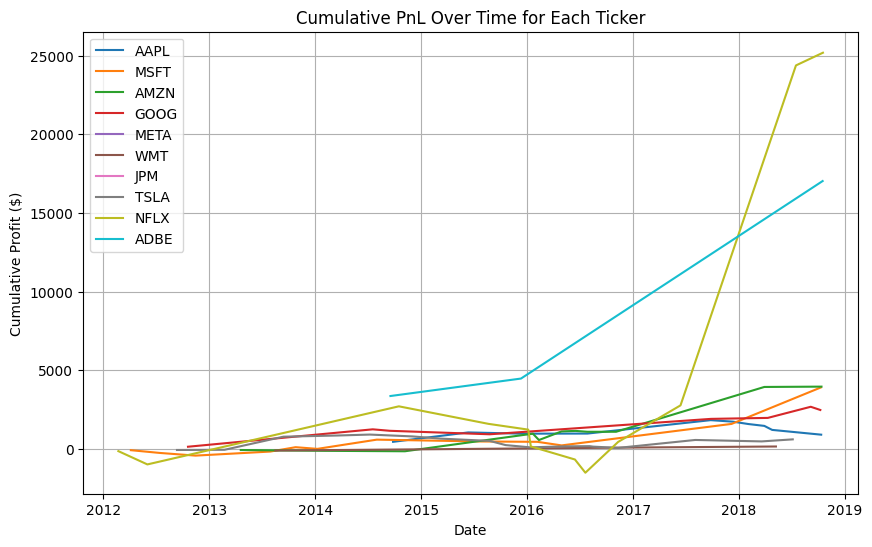

In [83]:


# List of tickers you want to run the strategy for
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    if os.path.exists(sentiment_file):
        print(f"Sentiment file for {ticker} already exists. Skipping file creation.")
    else:
        # Save the sentiment data to a CSV file if it doesn't exist
        date_sentiment.to_csv(sentiment_file)
        print(f"Sentiment data for {ticker} saved in {sentiment_file}")

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2012-01-01'
    end_date = '2018-12-12'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    result = subprocess.run(
        ['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    # Capture the output of the subprocess (the result of the backtest)
    output = result.stdout

    cumulative_pnls = []  # To store the cumulative PnL over time
    cumulative_profit = 0  # To track the total profit/loss

    # Assuming the backtest script prints the operation profits in the format:
    # 'OPERATION PROFIT, GROSS 455.42, NET 455.42'
    for line in output.splitlines():
        if 'OPERATION PROFIT' in line:  # Adjust this if your backtest script outputs it differently
            net_profit = float(line.split('NET')[-1].strip())  # Extract the net profit for each trade
            cumulative_profit += net_profit  # Update cumulative profit
            cumulative_pnls.append((line.split(',')[0].strip(), cumulative_profit))  # Append date and cumulative profit

    # Store the cumulative PnL results for the current ticker
    results_tickers[ticker] = cumulative_pnls
    print(f"Backtest complete for {ticker}. Cumulative PnL data collected.")

# Plot the cumulative PnL for each ticker
plt.figure(figsize=(10, 6))
for ticker, cumulative_pnls in results_tickers.items():
    # Convert the list of tuples (date, cumulative profit) into a DataFrame
    df = pd.DataFrame(cumulative_pnls, columns=['Date', 'CumulativePnL'])
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
    plt.plot(df['Date'], df['CumulativePnL'], label=ticker)

plt.title("Cumulative PnL Over Time for Each Ticker")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.show()


### Now we run for timeframe of 2012 to 2014

In [82]:


# List of tickers you want to run the strategy for
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    if os.path.exists(sentiment_file):
        print(f"Sentiment file for {ticker} already exists. Skipping file creation.")
    else:
        # Save the sentiment data to a CSV file if it doesn't exist
        date_sentiment.to_csv(sentiment_file)
        print(f"Sentiment data for {ticker} saved in {sentiment_file}")

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2012-01-01'
    end_date = '2014-12-31'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    result = subprocess.run(
        ['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    # Capture the output of the subprocess (the result of the backtest)
    output = result.stdout
    print(f"Backtest Output for {ticker}:")
    print(output)  # This will print the full output to help debug

    strategy_profit = None

    # Assuming the backtest script prints the strategy profit in the format:
    # 'StrategyProfit: 5000.00' or 'Profit: 5000.00'
    # We need to extract this profit from the output
    for line in output.splitlines():
        print(f"Line in Output: {line}")  # Debugging each line of output
        if 'StrategyProfit' in line:  # Adjust this if your backtest script outputs it differently
            strategy_profit = float(line.split(':')[-1].strip())
        # Alternatively, if the backtest outputs something like 'Profit' you can check for it:
        elif 'Profit' in line:
            strategy_profit = float(line.split(':')[-1].strip())

    # If the strategy profit is found, store it in the results dictionary
    if strategy_profit is not None:
        results_tickers[ticker] = {
            'PerUnitStartPrice': 100,  # Example value, replace with actual value if available
            'StrategyProfit': strategy_profit
        }

    print(f"Backtest complete for {ticker}. Strategy Profit: {strategy_profit}")

# Convert the results dictionary to a DataFrame for easier display
results_df_2012_2014 = pd.DataFrame.from_dict(results_tickers, orient='index')

# Display the results DataFrame



Sentiment file for AAPL already exists. Skipping file creation.
Backtest Output for AAPL:
Running strategy for AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.27
2013-12-16, BUY EXECUTED, Price: 17.29, Cost: 1729.32, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.70
2014-09-26, SELL EXECUTED, Price: 21.85, Cost: 1729.32, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 455.42, NET 455.42
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.72
2014-10-22, BUY EXECUTED, Price: 22.80, Cost: 2280.30, Comm 0.00
2014-12-30, (MA Period 15) Ending Value 100680.87
Start Portfolio value: 100000.00
Final Portfolio Value: 100680.87
Profit: 680.87


Line in Output: Running strategy for AAPL
Line in Output: Starting Portfolio Value: 100000.00
Line in Output: 2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.27
Line in Output: 2013-12-16, BUY EXECUTED, Price: 17.29,

In [ ]:
print(results_df_2012_2014)
print(       )
print("Total Profit: ")
print(sum(results_df_2012_2014['StrategyProfit']))

      PerUnitStartPrice  StrategyProfit
AAPL                100          680.87
MSFT                100          594.82
AMZN                100         -143.65
GOOG                100         1156.71
META                100            0.00
WMT                 100          -98.35
JPM                 100         2209.14
TSLA                100          799.60
NFLX                100         2711.71
ADBE                100         3367.00

Total Profit: 
11277.85


Sentiment file for AAPL already exists. Skipping file creation.
Backtest complete for AAPL. Cumulative PnL data collected.
Sentiment file for MSFT already exists. Skipping file creation.
Backtest complete for MSFT. Cumulative PnL data collected.
Sentiment file for AMZN already exists. Skipping file creation.
Backtest complete for AMZN. Cumulative PnL data collected.
Sentiment file for GOOG already exists. Skipping file creation.
Backtest complete for GOOG. Cumulative PnL data collected.
Sentiment file for META already exists. Skipping file creation.
Backtest complete for META. Cumulative PnL data collected.
Sentiment file for WMT already exists. Skipping file creation.
Backtest complete for WMT. Cumulative PnL data collected.
Sentiment file for JPM already exists. Skipping file creation.
Backtest complete for JPM. Cumulative PnL data collected.
Sentiment file for TSLA already exists. Skipping file creation.
Backtest complete for TSLA. Cumulative PnL data collected.
Sentiment file for N

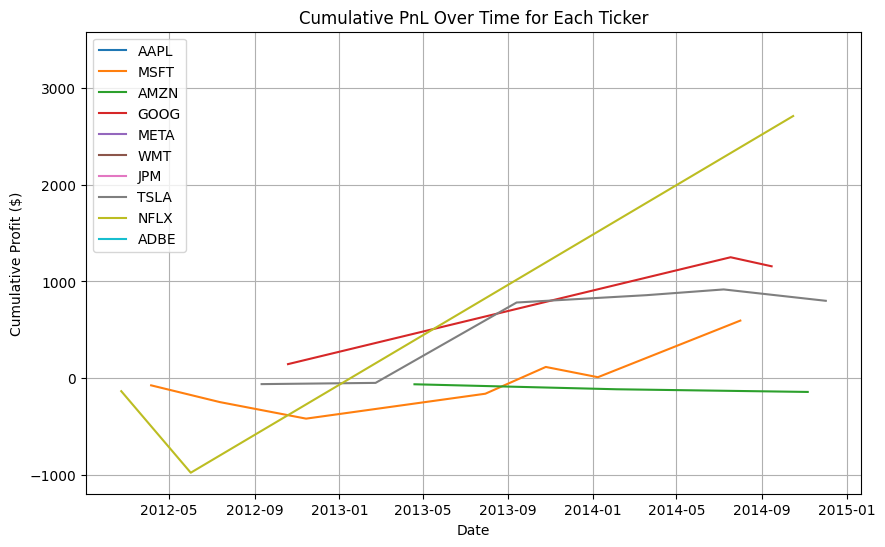

In [84]:
# List of tickers you want to run the strategy for
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    if os.path.exists(sentiment_file):
        print(f"Sentiment file for {ticker} already exists. Skipping file creation.")
    else:
        # Save the sentiment data to a CSV file if it doesn't exist
        date_sentiment.to_csv(sentiment_file)
        print(f"Sentiment data for {ticker} saved in {sentiment_file}")

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2012-01-01'
    end_date = '2014-12-31'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    result = subprocess.run(
        ['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    # Capture the output of the subprocess (the result of the backtest)
    output = result.stdout

    cumulative_pnls = []  # To store the cumulative PnL over time
    cumulative_profit = 0  # To track the total profit/loss

    # Assuming the backtest script prints the operation profits in the format:
    # 'OPERATION PROFIT, GROSS 455.42, NET 455.42'
    for line in output.splitlines():
        if 'OPERATION PROFIT' in line:  # Adjust this if your backtest script outputs it differently
            net_profit = float(line.split('NET')[-1].strip())  # Extract the net profit for each trade
            cumulative_profit += net_profit  # Update cumulative profit
            cumulative_pnls.append((line.split(',')[0].strip(), cumulative_profit))  # Append date and cumulative profit

    # Store the cumulative PnL results for the current ticker
    results_tickers[ticker] = cumulative_pnls
    print(f"Backtest complete for {ticker}. Cumulative PnL data collected.")

# Plot the cumulative PnL for each ticker
plt.figure(figsize=(10, 6))
for ticker, cumulative_pnls in results_tickers.items():
    # Convert the list of tuples (date, cumulative profit) into a DataFrame
    df = pd.DataFrame(cumulative_pnls, columns=['Date', 'CumulativePnL'])
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
    plt.plot(df['Date'], df['CumulativePnL'], label=ticker)

plt.title("Cumulative PnL Over Time for Each Ticker")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.show()


### Now we run for timeframe of 2016 to 2018

In [ ]:
import subprocess
import os
import pandas as pd

# List of tickers you want to run the strategy for
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    if os.path.exists(sentiment_file):
        print(f"Sentiment file for {ticker} already exists. Skipping file creation.")
    else:
        # Save the sentiment data to a CSV file if it doesn't exist
        date_sentiment.to_csv(sentiment_file)
        print(f"Sentiment data for {ticker} saved in {sentiment_file}")

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2016-01-01'
    end_date = '2018-12-31'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    result = subprocess.run(
        ['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    # Capture the output of the subprocess (the result of the backtest)
    output = result.stdout
    print(f"Backtest Output for {ticker}:")
    print(output)  # This will print the full output to help debug

    strategy_profit = None

    # Assuming the backtest script prints the strategy profit in the format:
    # 'StrategyProfit: 5000.00' or 'Profit: 5000.00'
    # We need to extract this profit from the output
    for line in output.splitlines():
        print(f"Line in Output: {line}")  # Debugging each line of output
        if 'StrategyProfit' in line:  # Adjust this if your backtest script outputs it differently
            strategy_profit = float(line.split(':')[-1].strip())
        # Alternatively, if the backtest outputs something like 'Profit' you can check for it:
        elif 'Profit' in line:
            strategy_profit = float(line.split(':')[-1].strip())

    # If the strategy profit is found, store it in the results dictionary
    if strategy_profit is not None:
        results_tickers[ticker] = {
            'PerUnitStartPrice': 100,  # Example value, replace with actual value if available
            'StrategyProfit': strategy_profit
        }

    print(f"Backtest complete for {ticker}. Strategy Profit: {strategy_profit}")

# Convert the results dictionary to a DataFrame for easier display
results_df_2016_2018 = pd.DataFrame.from_dict(results_tickers, orient='index')




Sentiment file for AAPL already exists. Skipping file creation.
Backtest Output for AAPL:
Running strategy for AAPL
Starting Portfolio Value: 100000.00
2016-03-15, Previous Sentiment 0.09, New Sentiment 0.66 BUY CREATE, 23.81
2016-03-16, BUY EXECUTED, Price: 23.82, Cost: 2382.15, Comm 0.00
2016-07-26, Previous Sentiment 0.93, New Sentiment 0.14 SELL CREATE, 22.15
2016-07-27, SELL EXECUTED, Price: 23.89, Cost: 2382.15, Comm 0.00
2016-07-27, OPERATION PROFIT, GROSS 6.71, NET 6.71
2016-12-13, Previous Sentiment 0.15, New Sentiment 0.74 BUY CREATE, 26.67
2016-12-14, BUY EXECUTED, Price: 26.63, Cost: 2663.50, Comm 0.00
2017-09-22, Previous Sentiment 0.58, New Sentiment 0.08 SELL CREATE, 35.60
2017-09-25, SELL EXECUTED, Price: 35.16, Cost: 2663.50, Comm 0.00
2017-09-25, OPERATION PROFIT, GROSS 852.40, NET 852.40
2017-11-06, Previous Sentiment 0.14, New Sentiment 0.64 BUY CREATE, 40.85
2017-11-07, BUY EXECUTED, Price: 40.77, Cost: 4076.60, Comm 0.00
2017-12-08, Previous Sentiment 0.57, New Se

In [ ]:
print(results_df_2016_2018)
print(       )
print("Total Profit: ")
print(sum(results_df_2016_2018['StrategyProfit']))

      PerUnitStartPrice  StrategyProfit
AAPL                100          -63.25
MSFT                100         3196.05
AMZN                100         2393.15
GOOG                100         1567.65
META                100            0.00
WMT                 100          192.28
JPM                 100            0.00
TSLA                100          725.73
NFLX                100        25020.00
ADBE                100        12551.00

Total Profit: 
45582.61


Sentiment file for AAPL already exists. Skipping file creation.
Backtest complete for AAPL. Cumulative PnL data collected.
Sentiment file for MSFT already exists. Skipping file creation.
Backtest complete for MSFT. Cumulative PnL data collected.
Sentiment file for AMZN already exists. Skipping file creation.
Backtest complete for AMZN. Cumulative PnL data collected.
Sentiment file for GOOG already exists. Skipping file creation.
Backtest complete for GOOG. Cumulative PnL data collected.
Sentiment file for META already exists. Skipping file creation.
Backtest complete for META. Cumulative PnL data collected.
Sentiment file for WMT already exists. Skipping file creation.
Backtest complete for WMT. Cumulative PnL data collected.
Sentiment file for JPM already exists. Skipping file creation.
Backtest complete for JPM. Cumulative PnL data collected.
Sentiment file for TSLA already exists. Skipping file creation.
Backtest complete for TSLA. Cumulative PnL data collected.
Sentiment file for N

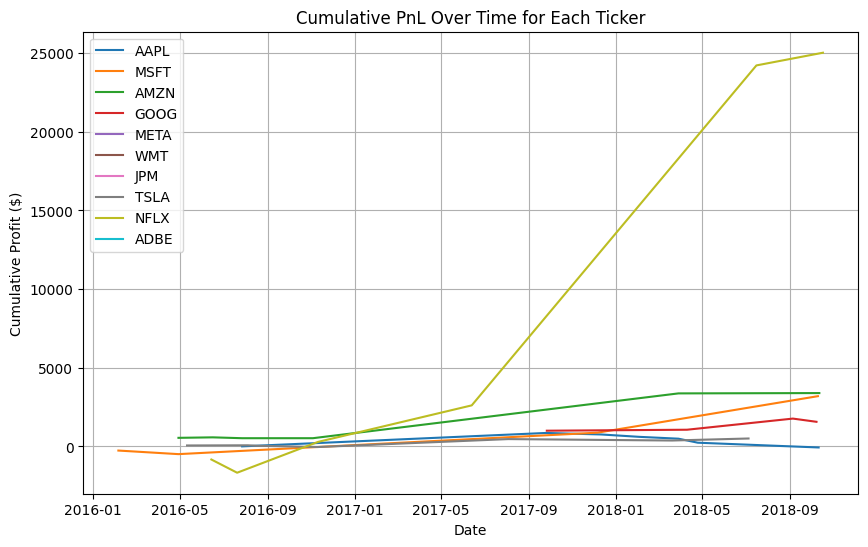

In [85]:


# List of tickers you want to run the strategy for
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE']
results_tickers = {}

# Iterate through each ticker to process and save sentiment data
for ticker in tickers:
    # Filter the data for the specific ticker
    date_sentiment = data_df[data_df['ticker'].isin([ticker])]
    date_sentiment = date_sentiment[['date', 'sentiment_lex']]
    date_sentiment['date'] = pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment = date_sentiment.set_index('date')['sentiment_lex']

    # Save the sentiment data to a CSV file specific to the ticker
    sentiment_file = f'Data/date_sentiment_{ticker.lower()}.csv'  # Save with ticker in filename
    if os.path.exists(sentiment_file):
        print(f"Sentiment file for {ticker} already exists. Skipping file creation.")
    else:
        # Save the sentiment data to a CSV file if it doesn't exist
        date_sentiment.to_csv(sentiment_file)
        print(f"Sentiment data for {ticker} saved in {sentiment_file}")

    # Run the backtest strategy using subprocess for each ticker
    start_date = '2016-01-01'
    end_date = '2018-12-31'
    
    # Run the backtest strategy by passing the sentiment file for the current ticker
    result = subprocess.run(
        ['python3', 'backtest_strategy.py', ticker, start_date, end_date, sentiment_file],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )

    # Capture the output of the subprocess (the result of the backtest)
    output = result.stdout

    cumulative_pnls = []  # To store the cumulative PnL over time
    cumulative_profit = 0  # To track the total profit/loss

    # Assuming the backtest script prints the operation profits in the format:
    # 'OPERATION PROFIT, GROSS 455.42, NET 455.42'
    for line in output.splitlines():
        if 'OPERATION PROFIT' in line:  # Adjust this if your backtest script outputs it differently
            net_profit = float(line.split('NET')[-1].strip())  # Extract the net profit for each trade
            cumulative_profit += net_profit  # Update cumulative profit
            cumulative_pnls.append((line.split(',')[0].strip(), cumulative_profit))  # Append date and cumulative profit

    # Store the cumulative PnL results for the current ticker
    results_tickers[ticker] = cumulative_pnls
    print(f"Backtest complete for {ticker}. Cumulative PnL data collected.")

# Plot the cumulative PnL for each ticker
plt.figure(figsize=(10, 6))
for ticker, cumulative_pnls in results_tickers.items():
    # Convert the list of tuples (date, cumulative profit) into a DataFrame
    df = pd.DataFrame(cumulative_pnls, columns=['Date', 'CumulativePnL'])
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
    plt.plot(df['Date'], df['CumulativePnL'], label=ticker)

plt.title("Cumulative PnL Over Time for Each Ticker")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True)
plt.show()
